# Imports

In [1]:
%load_ext autoreload
%autoreload 2

# SEED

In [2]:
import tensorflow as tf
import os
import numpy as np
import random

In [4]:
#SEED=0
#os.environ['PYTHONHASHSEED']=str(SEED)
#os.environ['TF_DETERMINISTIC_OPS'] = '1'
#os.environ['TF_CUDNN_DETERMINISTIC'] = '1'  # new flag present in tf 2.0+
#random.seed(SEED)
#np.random.seed(SEED)
#tf.random.set_seed(SEED)

In [3]:
import pandas as pd
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer
from tqdm.notebook import trange, tqdm
from ipywidgets import IntProgress
plt.style.use('default')

In [4]:
tf.__version__

'2.8.0'

In [6]:
#from google.colab import drive
#drive.mount('/content/drive')
%cd -q ../..
#%cd /content/drive/Othercomputers/Mein\ Laptop/50sources/
from utils import util
from utils import executor
from nn_utils import window as wd
from nn_utils.models import create_nnar, create_dense_lstm_dense
%cd -q -

In [8]:
manager = executor.GasModelManager()

# Inspect

* Forecasts start at 2012 10 23
* Huge variance stops at 2012 03 28

In [9]:
df_optimal = manager.get_train(70)

Train dates are from "2011-10-01 00:00:00" to "2018-07-25 00:00:00", 2490 elements


<AxesSubplot:xlabel='day'>

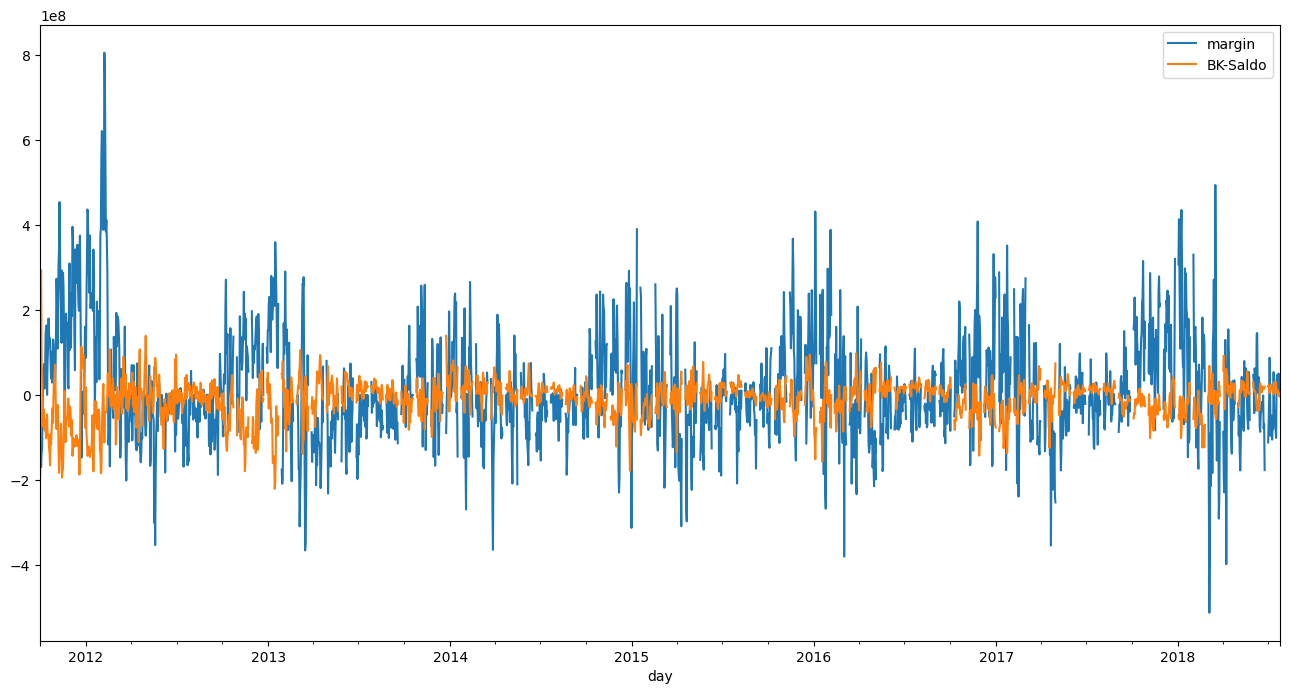

In [10]:
df_optimal[["margin", "BK-Saldo"]].plot(figsize=(16,8))

# Define compile convenience method

In [11]:
class WeightedLoss:
    """
    !DO NOT! INHERIT FROM tf.keras.Losses because it further processes the 
    output with some weird reduce and weight logic
    """

    def __init__(self, weights) -> None:
        self.weights = tf.convert_to_tensor(weights)

    def __call__(self, y_true, y_pred):
        y_pred = tf.convert_to_tensor(y_pred)
        y_true = tf.cast(y_true, y_pred.dtype)
        # squared_loss = tf.math.square(y_pred - y_true)
        # squared_loss = tf.math.squared_difference(y_pred, y_true)
        # ABSOLUTE
        squared_loss = tf.math.abs(tf.math.subtract(y_pred, y_true))
        reduced = tf.reduce_mean(input_tensor=squared_loss, axis=-1) # or squeeze
        #reduced = tf.squeeze(squared_loss)

        calculated_shape = tf.shape(reduced)
        broadcasted_weights = tf.broadcast_to(self.weights, calculated_shape)

        # Mit Hilfe von sample_weight wird jeder Datenpunkt (z.B. 3 Tage) mit einem custom weight "gemittelt"
        # Nun müssen diese gemittelten Werte noch addiert werden, jedoch nur pro Datenpunkt
        # Zum schluss muss der Durchschnitt vom Batch berechnet werden.
        reduced = tf.multiply(reduced, broadcasted_weights)
        reduced = tf.reduce_sum(reduced)
        reduced = tf.divide(reduced, tf.cast(calculated_shape[0], y_pred.dtype))

        return reduced

In [12]:
def compile_and_fit(model, train, optimizer=tfa.optimizers.COCOB(), early_watch='loss', val=None, weights=None, patience=1, epochs=1, run_eagerly=False, verbose='auto'):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor=early_watch,
                                                      patience=patience,
                                                      mode='min',
                                                      restore_best_weights=True)


    loss = WeightedLoss(weights=weights) if weights != None else tf.losses.MeanSquaredError()
    model.compile(loss=loss,
                  #optimizer=tf.optimizers.Adam(learning_rate=learning_rate),
                  optimizer=optimizer,
                  metrics=[tf.metrics.MeanAbsoluteError()])

    model.run_eagerly = run_eagerly

    callbacks = [early_stopping] if patience > 0 else None
    history = model.fit(train, epochs=epochs,
                        validation_data=val, callbacks=callbacks, verbose=verbose)
    return history

# Model Wrapper

In [13]:
class ModelWrapper:
  def __init__(self, model, is_object=False, id=None, **kwargs):
    if not is_object:
      # instantiate model
      self.model = model(**kwargs)
    else:
      self.model = model
    # construct name
    self.name = type(self.model).__name__
    for k,v in kwargs.items():
      if type(v) is bool and v == True:
        self.name = self.name + f" {k[:2].upper()}"
      else:
        self.name = self.name + f" {k[0].upper()}{v}"
    
    if id is not None:
      self.name = self.name + f" {id}"



In [14]:
class ModelWrapperV2:
  def __init__(self, model, params, name=None):
    # take model and args
    self.model = model
    self.params = params
    # construct name
    if name:
      self.name = name
    else:
      self.name = type(self.model).__name__

    for k,v in params.items():
      if type(v) is bool and v == True:
        self.name = self.name + f" {k[:2].upper()}"
      else:
        self.name = self.name + f" {k[0].upper()}{v}"

# Training Data

In [15]:
#df_gws_train,df_gws_val,df_gws_test = util.train_val_test_split(merged_lagged_full_df, train_size=0.7, val_only=False)

#tmp_train = manager.get_train(0)
#df_gws_train = tmp_train[:int(len(tmp_train)*0.8)]
#df_gws_val = tmp_train[int(len(tmp_train)*0.8):]
#df_gws_train,df_gws_val,_ = util.train_val_test_split(df_gws_train, train_size=0.7, val_only=True)
df_gws_train = manager.get_train(30)
df_gws_val = manager.get_train(50)
df_gws_val = df_gws_val[df_gws_val.index > df_gws_train.index[-1]]

print(f"Train dates are from \"{df_gws_train.index[0]}\" to \"{df_gws_train.index[-1]}\", {len(df_gws_train)} elements")
print(f"Val dates are from \"{df_gws_val.index[0]}\" to \"{df_gws_val.index[-1]}\", {len(df_gws_val)} elements")
#print(f"Test dates are from \"{df_gws_test.index[0]}\" to \"{df_gws_test.index[-1]}\", {len(df_gws_test)} elements")

standardiser = util.Standardiser2(df_gws_train, min_max=False)
train_stand,val_stand = standardiser(df_gws_train,df_gws_val)

w_size = wd.WindowGenerator(input_width=7, label_width=1, shift=1+1, handle_nan=True, bonus_day_columns=["holiday"],
                        label_columns=['margin'], train_df=train_stand, val_df=val_stand)
train_count=sum(1 for _ in w_size.train.unbatch())
val_count=sum(1 for _ in w_size.val.unbatch())
print(f"""Training datapoins {train_count}, val datapoints {val_count}, train/val {train_count/(train_count+val_count)}""")
mean_pred = np.repeat(df_gws_val["margin"].dropna().mean(), len(df_gws_val["margin"].dropna()))
labels = df_gws_val["margin"].dropna().to_numpy()
print(tf.keras.losses.MeanAbsoluteError()(labels, mean_pred).numpy())

Train dates are from "2011-10-01 00:00:00" to "2015-04-12 00:00:00", 1290 elements
Train dates are from "2011-10-01 00:00:00" to "2016-12-02 00:00:00", 1890 elements
Train dates are from "2011-10-01 00:00:00" to "2015-04-12 00:00:00", 1290 elements
Val dates are from "2015-04-13 00:00:00" to "2016-12-02 00:00:00", 600 elements
Training datapoins 861, val datapoints 320, train/val 0.729043183742591
78367200.0


# Train Model/Grid Search/Experiments Area

In [16]:
#weights = [[0.5, 0.125, 0.125, 0.125, 0.125]]
weights = None
out_steps = 1
#out_steps = 5
shift=1

results = {}

# GRID SEARCH
batch_size = [8]
grid_dropout = [0.2]
grid_n = [32]
#grid_activation = ["selu", "relu", "elu", "swish"]
grid_activation = ["relu"]
grid_input_width_param = [7]
grid_p_param = [1]
grid_m_param = [6]
grid_seed_param = [50]
grid_data_param = [30]

gen = [{"data": data, "seed": s, "batch_size": bs, "dropout": d, "n": n, "activation": a, "input_width": i, "p": p, "m": m} 
  for bs in batch_size
  for d in grid_dropout 
  for n in grid_n 
  for a in grid_activation 
  for i in grid_input_width_param 
  for p in grid_p_param
  for m in grid_m_param
  for s in grid_seed_param
  for data in grid_data_param
  ]

#optimizer = tf.optimizers.Adam(learning_rate=0.001)
optimizer = tfa.optimizers.COCOB()
shuffle=False

max_slots = len(manager.get_slots())

prog = tqdm(range(len(gen)))
for i in prog:
  params = gen[i]

  keep_cols=['BK-Saldo', 'ENTRY', 'EXIT', 'RLM', 'SLP', 'NK-Saldo', 'holiday', 'margin',
    #'SystemSell', 'SystemBuy', 
      'tavg_mean', 'tavg_std', 'tmin_mean', 'tmin_std',
       'tmax_mean', 'tmax_std', 'prcp_mean', 'prcp_std', 'snow_mean',
       'snow_std', 'wdir_mean', 'wdir_std', 'wspd_mean', 'wspd_std',
       'wpgt_mean', 'wpgt_std', 'pres_mean', 'pres_std', 'tsun_mean', 'tsun_std', 
       'Dow sin', 'Dow cos', 'Year sin', 'Year cos',
       #'rlm_imputation', 'exit_imputation', 'entry_imputation'
      ]
  #keep_cols=None
  bonus_day_cols=[
    'holiday', 'SLP', 'tavg_mean', 'tavg_std', 'tsun_mean', 'tsun_std', 'prcp_mean', 'prcp_std', 'pres_mean', 'pres_std',
    'rlm_imputation', 'exit_imputation', 'entry_imputation'
    ]
  targets=["margin"]
  out_features = len(targets)

  #if keep_cols:
  #  train_stand_filtered = train_stand[keep_cols]
  #  val_stand_filtered = val_stand[keep_cols]
  #else:
  #  train_stand_filtered = train_stand
  #  val_stand_filtered = val_stand
  train_end_data = params["data"]
  train_end_data = min(max_slots-20, train_end_data)
  val_end_data = train_end_data+20
  df_gws_train = manager.get_train(train_end_data)
  df_gws_val = manager.get_train(val_end_data)
  df_gws_val = df_gws_val[df_gws_val.index > df_gws_train.index[-1]]

  standardiser = util.Standardiser2(df_gws_train, min_max=False)
  train_stand,val_stand = standardiser(df_gws_train,df_gws_val)
  
  
  w2 = wd.WindowGenerator(batch_size=params["batch_size"], input_width=params["input_width"], label_width=out_steps, 
                        shift=out_steps+shift, handle_nan=True, shuffle_ds=shuffle, seed=params["seed"], bonus_day_columns=bonus_day_cols,
                        keep_past_cols=keep_cols,
                        label_columns=targets, train_df=train_stand, val_df=val_stand)

  p = min(params["p"], params["input_width"])
  m = min(params["m"], params["input_width"])
  if p > m:
    m = p
  
  
  models = [

            #ModelWrapperV2(NNARNaive(p=p, m=m, dropout=params["dropout"], batch_norm=False, activation=params["activation"], n=params["n"], out_steps=out_steps, out_features=out_features), params),
            ModelWrapperV2(create_nnar(w2.val, n=params["n"], p=p, m=m, activation=params["activation"], dropout=params["dropout"], out_steps=out_steps, out_features=out_features), params, name="nnar_with_future"),
            #ModelWrapperV2(EncoderDecoder(ds=w2.train, n=params["n"], p=p, m=m, out_steps=out_steps, out_features=out_features, activation=params["activation"], dropout=params["dropout"]), params, name="encoder_decoder"),
            #ModelWrapperV2(create_dense_lstm_dense(ds=w2.train,n=params["n"], p=p, m=m, out_steps=out_steps, out_features=out_features, activation=params["activation"], dropout=params["dropout"]), params, name="dense_lstm_dense")
  ]

  labels = np.concatenate([y for x, y in w2.val], axis=0)
  #labels_denorm = (labels * standardiser.divide[target]) + standardiser.substract[target]
  div = [standardiser.divide[target] for target in targets]
  sub = [standardiser.substract[target] for target in targets]
  labels_denorm = (labels * div) + sub

  for model_wrapper in models:
    if model_wrapper.name in results:
      continue

    random.seed(params["seed"])
    np.random.seed(params["seed"])
    tf.random.set_seed(params["seed"])

    # train
    history = compile_and_fit(verbose=0, optimizer=optimizer, weights=weights, model=model_wrapper.model, 
      train=w2.train, val=w2.val, early_watch='val_loss', epochs=200, patience=15)
    # predict
    pred = model_wrapper.model.predict(w2.val)
    pred_denorm = (pred * div) + sub
    # mae
    mae_one_day = tf.keras.losses.MeanAbsoluteError()(labels_denorm[:,:1,:], pred_denorm[:,:1,:])
    mae_remaining = tf.keras.losses.MeanAbsoluteError()(labels_denorm[:,1:,:], pred_denorm[:,1:,:])
    mae_combined = tf.keras.losses.MeanAbsoluteError()(labels_denorm, pred_denorm)
    desc = f"last mae_one_day {mae_one_day}, mae_combined {mae_combined} [{model_wrapper.name}]"
    prog.set_description(desc)
    print(desc)
    # save
    results[f"{model_wrapper.name}"] = {"predictions": pred_denorm, "history": history, "mae_one_day": mae_one_day, "mae-remaining": mae_remaining, "mae_combined": mae_combined}

    del model_wrapper.model


  0%|          | 0/1 [00:00<?, ?it/s]

Train dates are from "2011-10-01 00:00:00" to "2015-04-12 00:00:00", 1290 elements
Train dates are from "2011-10-01 00:00:00" to "2016-12-02 00:00:00", 1890 elements
last mae_one_day 60630976.0, mae_combined 60630976.0 [nnar_with_future D30 S50 B8 D0.2 N32 Arelu I7 P1 M6]


In [17]:
df_results = pd.DataFrame({name:{'mae_one_day': props['mae_one_day'].numpy(), 'mae_remaining': props['mae-remaining'].numpy()} for name, props in results.items()}).T
#df_results = pd.DataFrame({name:{'mae_one_day': props['mae_one_day'].numpy(), 'mae_remaining': 0} for name, props in results.items()}).T
df_results.sort_values('mae_one_day').head(n=30)

,mae_one_day,mae_remaining
nnar_with_future D30 S50 B8 D0.2 N32 Arelu I7 P1 M6,60630976.0,0.0


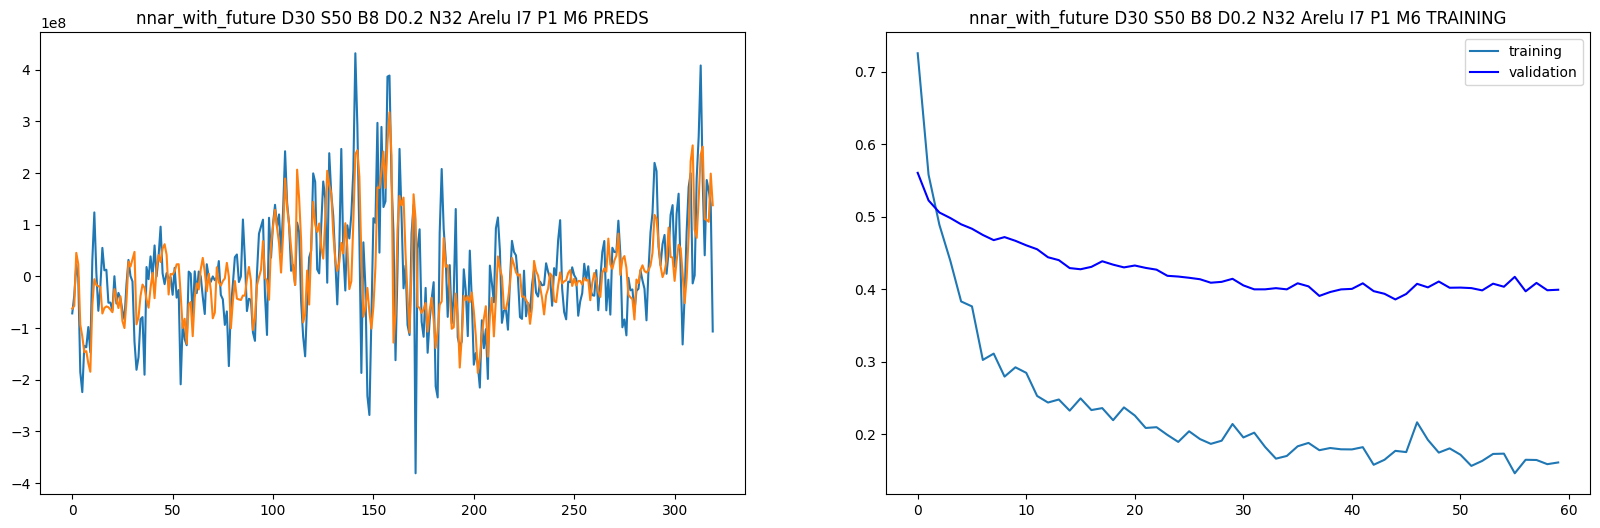

In [18]:
top_3 = df_results.sort_values('mae_one_day')[:min(5, len(df_results.index))].index

length = len(top_3)
fig, axs = plt.subplots(length, 2, figsize=(20,length*6), squeeze=False)

for i in range(0, length):
  name = top_3[i]
  axs[i,0].set_title(f'{name} PREDS')
  axs[i,0].plot(labels_denorm[::out_steps].flatten())
  axs[i,0].plot(results[top_3[i]]["predictions"][::out_steps].flatten())
  #axs[i,0].plot(labels_denorm.flatten())
  #axs[i,0].plot(results[top_3[i]]["predictions"].flatten())

  axs[i,1].set_title(f'{top_3[i]} TRAINING')
  axs[i,1].plot(results[top_3[i]]["history"].history["loss"], label="training")
  axs[i,1].plot(results[top_3[i]]["history"].history["val_loss"], color='b', label="validation")
  axs[i,1].legend()

# Prediction area

In [20]:
slots = manager.get_slots()

In [21]:
def split_window(features, window):
        """features: tensor with dimension: (batch_size,inputs,columns)"""
        inputs = features[window.input_slice, :]
        extra = features[window.bonus_slice, :]

        if window.keep_past_cols is not None:
            inputs = tf.stack(
                [inputs[:, window.column_indices[name]] for name in window.keep_past_cols],
                axis=-1)

        if window.bonus_day_columns is not None:
            extra = tf.stack(
                [extra[:, window.column_indices[name]] for name in window.bonus_day_columns],
                axis=-1
            )

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([window.input_width, None])
        extra.set_shape([window.shift, None])

        return inputs, extra

In [22]:
keep_cols=['BK-Saldo', 'ENTRY', 'EXIT', 'RLM', 'SLP', 'NK-Saldo', 'holiday', 'margin',
    #'SystemSell', 'SystemBuy', 
      'tavg_mean', 'tavg_std', 'tmin_mean', 'tmin_std',
       'tmax_mean', 'tmax_std', 'prcp_mean', 'prcp_std', 'snow_mean',
       'snow_std', 'wdir_mean', 'wdir_std', 'wspd_mean', 'wspd_std',
       'wpgt_mean', 'wpgt_std', 'pres_mean', 'pres_std', 'tsun_mean', 'tsun_std', 
       'Dow sin', 'Dow cos', 'Year sin', 'Year cos',
       #'rlm_imputation', 'exit_imputation', 'entry_imputation'
      ]
#keep_cols=None
bonus_day_cols=[
  'holiday', 'SLP', 'tavg_mean', 'tavg_std', 'tsun_mean', 'tsun_std', 'prcp_mean', 'prcp_std', 'pres_mean', 'pres_std',
  'rlm_imputation', 'exit_imputation', 'entry_imputation'
  ]
target="margin"

### Data settings
input_width=6
label_width=4
shift=label_width+2
out_steps=4
out_features=1

### Model settings

predictions = np.array([])
timestamps = []
all_losses = []
slots=manager.get_slots()

# How often to train
slots_zu_befuellen=len(slots)
first_training=True
train_mod=1
train_until_slot=108

repeats=3
start_seed=50

with tf.device('/device:CPU:0'):
  for i in trange(slots_zu_befuellen):
      # Make training
      if (i % train_mod == 0 and i <= train_until_slot) or first_training == True:
        print(f'Training for slot {i}...')
        first_training = False

        # get all training data BEFORE slot
        df_gesamt=manager.get_train(i)
        # use 25 days before slot for validation
        df_val=df_gesamt[-25:]
        df_train = df_gesamt[df_gesamt.index < df_val.index[0]]
        
        standardiser = util.Standardiser2(df_train, min_max=False)
        train_stand,val_stand = standardiser(df_train, df_val)

        gesamt_standardiser = util.Standardiser2(df_gesamt, min_max=False)
        gesamt_stand, = gesamt_standardiser(df_gesamt)

        w1 = wd.WindowGenerator(batch_size=8, input_width=input_width, label_width=label_width, shift=shift, 
                                handle_nan=True, bonus_day_columns=bonus_day_cols, keep_past_cols=keep_cols,
                                label_columns=['margin'], train_df=train_stand, val_df=val_stand)

        w_gesamt = wd.WindowGenerator(batch_size=8, input_width=input_width, label_width=label_width, shift=shift, 
                                handle_nan=True, bonus_day_columns=bonus_day_cols, keep_past_cols=keep_cols,
                                label_columns=['margin'], train_df=gesamt_stand, val_df=gesamt_stand)

        print(f'Finding optimal amount of epochs for slot {i}...')
        optimal_results = {"loss":[], "best_epoch":[], "seed":[]}
        current_seed = start_seed
        # find optimum number of training epochs and optimum seed
        for model_count in range(repeats):
          # set seed
          random.seed(current_seed)
          np.random.seed(current_seed)
          tf.random.set_seed(current_seed)
          # eval on mini val
          #model = create_nnar(w1.train, 32, 1, 6, "swish")
          model = create_dense_lstm_dense(ds=w1.train, n=32, p=6, activation="swish", dropout=0.2,
            out_steps=out_steps, out_features=out_features)
          test_history=compile_and_fit(weights=None, model=model, train=w1.train, val=w1.val, 
                        early_watch='val_loss', epochs=100, patience=25, verbose=0)
          ################################################################
          ### find out which epoch has the lowest error on our mini val ##
          ################################################################
          tmp_best_epoch = np.argmin(test_history.history["val_loss"]) + 1
          # Loss on mini val
          predicted = model.predict(w1.val)
          norm_pred = (predicted * standardiser.divide["margin"]) + standardiser.substract["margin"]
          labels = np.concatenate([y for x, y in w1.val], axis=0)
          labels_denorm = (labels * standardiser.divide["margin"]) + standardiser.substract["margin"]
          loss = tf.keras.losses.MeanAbsoluteError()(labels_denorm, norm_pred).numpy()
          print(f"Loss for model {model_count} for slot {i} on mini val is {loss}")
          # save
          optimal_results["loss"].append(loss)
          optimal_results["best_epoch"].append(tmp_best_epoch)
          optimal_results["seed"].append(current_seed)
          # increase seed
          current_seed = current_seed + 10
        
        # out of our "repeats" tests, find best loss and corresponding best epoch and best seed
        best_seed_index = np.argmin(optimal_results["loss"])
        optimal_seed = optimal_results["seed"][best_seed_index]
        optimal_epoch = optimal_results["best_epoch"][best_seed_index]
        optimal_loss = optimal_results["loss"][best_seed_index]
        all_losses.append(optimal_loss)
        
        ###################################################################
        ### using optimum settings, now train with all data BEFORE slot ###
        ###################################################################
        # Train models
        print(f'Training model for slot {i} with {optimal_epoch} epochs and seed {optimal_seed}...')
        random.seed(optimal_seed)
        np.random.seed(optimal_seed)
        tf.random.set_seed(optimal_seed)
        #model = create_nnar(w_gesamt.train, 32, 1, 6, "swish")
        model = create_dense_lstm_dense(ds=w1.train, n=32, p=6, activation="swish", dropout=0.2,
          out_steps=out_steps, out_features=out_features)
        fit_history=compile_and_fit(weights=None, model=model, train=w_gesamt.train, val=None, 
                      early_watch='loss', epochs=optimal_epoch, patience=0, verbose=0)

      print(f"Predicting for slot {i}")
      # Make predictions
      # get preprocessed forecast
      forecast_df = manager.get_forecast(i, input_width)#[:-4]
      # normalize
      forecast_df_norm, = gesamt_standardiser(forecast_df)
      # make tensor
      tensor = tf.convert_to_tensor(forecast_df_norm.values, dtype=tf.float32)
      inputs, extra = split_window(tensor, w1)
      inputs_batched = tf.expand_dims(inputs, axis=0)
      extra_batched = tf.expand_dims(extra, axis=0)
      # make prediction and append
      #repeated_predictions=[]
      #for j in range(len(models)):
      ds = tf.data.Dataset.from_tensor_slices({"a": inputs_batched, "b": extra_batched}).batch(1)
      prediction = model.predict(ds)
      prediction = (prediction * gesamt_standardiser.divide["margin"]) + gesamt_standardiser.substract["margin"]
      #repeated_predictions.append(prediction.flatten())

      #mean_prediction = np.mean(repeated_predictions, axis=0)
      #repeated_predictions = np.repeat(prediction.flatten()[0], 5)
      #predictions = np.append(predictions, repeated_predictions)
      predictions = np.append(predictions, 0)
      predictions = np.append(predictions, prediction.flatten())
      for ts in slots[i]:
          timestamps.append(ts)

  0%|          | 0/109 [00:00<?, ?it/s]

Training for slot 0...
Train dates are from "2011-10-01 00:00:00" to "2012-10-24 00:00:00", 390 elements
Finding optimal amount of epochs for slot 0...
Loss for model 0 for slot 0 on mini val is 60518720.0
Training model for slot 0 with 39 epochs and seed 50...
Predicting for slot 0
Predicting for slot 1
Predicting for slot 2
Predicting for slot 3
Predicting for slot 4
Predicting for slot 5
Predicting for slot 6
Predicting for slot 7
Predicting for slot 8
Predicting for slot 9
Predicting for slot 10
Predicting for slot 11
Predicting for slot 12
Predicting for slot 13
Predicting for slot 14
Predicting for slot 15
Predicting for slot 16
Predicting for slot 17
Predicting for slot 18
Predicting for slot 19
Predicting for slot 20
Predicting for slot 21
Predicting for slot 22
Predicting for slot 23
Predicting for slot 24
Predicting for slot 25
Predicting for slot 26
Predicting for slot 27
Predicting for slot 28
Predicting for slot 29
Predicting for slot 30
Predicting for slot 31
Predicting f

# Estimate prediction losses and save results etc.

In [23]:
submission = pd.DataFrame(data=predictions, index=timestamps, columns=["margin"])
submission.index.name = "day"

In [24]:
len(predictions)

545

In [36]:
np_losses = np.sort(np.array(all_losses))
np_losses

array([2.0261790e+07, 2.1369324e+07, 2.2137590e+07, 2.3432728e+07,
       2.4723598e+07, 2.7147080e+07, 2.7215276e+07, 2.7755426e+07,
       2.8727658e+07, 2.9422632e+07, 2.9836692e+07, 3.1193740e+07,
       3.1890088e+07, 3.2021108e+07, 3.3186446e+07, 3.3452120e+07,
       3.3461300e+07, 3.4299344e+07, 3.4514844e+07, 3.4796792e+07,
       3.6221488e+07, 3.6680944e+07, 3.7931196e+07, 3.8297552e+07,
       3.8335480e+07, 3.8460860e+07, 3.9047304e+07, 3.9729948e+07,
       4.1019080e+07, 4.1067212e+07, 4.2883944e+07, 4.3007516e+07,
       4.3022180e+07, 4.3156628e+07, 4.3397336e+07, 4.3473928e+07,
       4.3692296e+07, 4.4181072e+07, 4.8384192e+07, 4.8837240e+07,
       4.9016952e+07, 4.9600888e+07, 5.0032816e+07, 5.0845640e+07,
       5.1448300e+07, 5.1598272e+07, 5.1876964e+07, 5.1984724e+07,
       5.2678032e+07, 5.2741404e+07, 5.3170852e+07, 5.3322268e+07,
       5.3698916e+07, 5.3983332e+07, 5.4031272e+07, 5.4669724e+07,
       5.5193452e+07, 5.6176572e+07, 5.6193456e+07, 5.6442428e

In [133]:
spike_dates = [slots[idx][0] for idx in np.argwhere(np_losses > 0.85e8).flatten()]

In [134]:
spike_dates

[Timestamp('2020-05-16 00:00:00'),
 Timestamp('2020-06-15 00:00:00'),
 Timestamp('2020-07-15 00:00:00'),
 Timestamp('2020-08-14 00:00:00'),
 Timestamp('2020-09-13 00:00:00'),
 Timestamp('2020-10-13 00:00:00'),
 Timestamp('2020-11-12 00:00:00'),
 Timestamp('2020-12-12 00:00:00'),
 Timestamp('2021-01-11 00:00:00'),
 Timestamp('2021-02-10 00:00:00'),
 Timestamp('2021-03-12 00:00:00'),
 Timestamp('2021-04-11 00:00:00'),
 Timestamp('2021-05-11 00:00:00'),
 Timestamp('2021-06-10 00:00:00'),
 Timestamp('2021-07-10 00:00:00'),
 Timestamp('2021-08-09 00:00:00'),
 Timestamp('2021-09-08 00:00:00')]

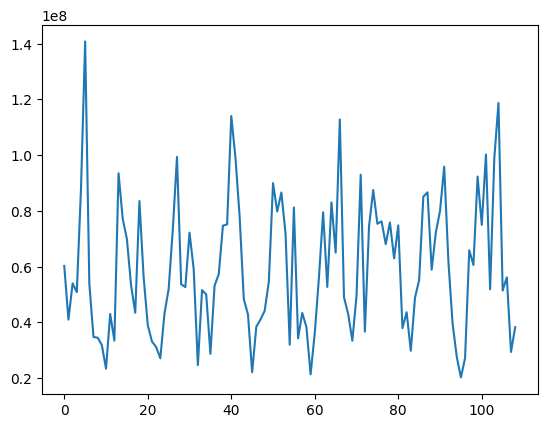

In [37]:
plt.figure(1)
plt.plot(all_losses)

In [38]:
np.mean(all_losses)

59416604.0

In [42]:
losses_df = pd.DataFrame(all_losses)
losses_df.index.name = "slot"
losses_df.columns = ["loss"]

In [43]:
losses_df

,loss
slot,
0,60268968.0
1,41019080.0
2,54031272.0
3,50845640.0
4,87696528.0
...,...
104,118702320.0
105,51448300.0
106,56193456.0


In [45]:
submission.head(n=20)

,margin
day,
2012-10-25,0.0
2012-10-26,183269680.0
2012-10-27,188175808.0
2012-10-28,165470400.0
2012-10-29,80532616.0
2012-11-24,0.0
2012-11-25,40135384.0
2012-11-26,56678876.0
2012-11-27,81329256.0


In [40]:
submission.to_csv('submission_dense_lstm_dense4d_090722.csv', sep=';', decimal='.')

In [44]:
losses_df.to_csv('losses_submission_dense_lstm_dense_090722.csv', sep=';', decimal='.')

In [57]:
submission_1d = pd.read_csv('submission.csv', index_col="day", sep=';', decimal='.')

In [52]:
submission_full = submission.copy()

In [71]:
submission_full.head()

,margin
day,
2012-10-25,0.0
2012-10-26,183269680.0
2012-10-27,188175808.0
2012-10-28,165470400.0
2012-10-29,80532616.0


In [72]:
submission_1d.head()

,margin
day,
2012-10-25,71354784.0
2012-10-26,71354784.0
2012-10-27,71354784.0
2012-10-28,71354784.0
2012-10-29,71354784.0


In [73]:
one_pred_df = submission_1d[["margin"]][::5]
one_pred_df

,margin
day,
2012-10-25,71354784.0
2012-11-24,90039632.0
2012-12-24,-44333600.0
2013-01-23,234547744.0
2013-02-22,75248720.0
...,...
2021-05-11,4588130.0
2021-06-10,-64443656.0
2021-07-10,-20914158.0


In [80]:
one_pred_df.index = pd.to_datetime(one_pred_df.index)

In [81]:
one_pred_df.index

DatetimeIndex(['2012-10-25', '2012-11-24', '2012-12-24', '2013-01-23',
               '2013-02-22', '2013-03-24', '2013-04-23', '2013-05-23',
               '2013-06-22', '2013-07-22',
               ...
               '2020-12-12', '2021-01-11', '2021-02-10', '2021-03-12',
               '2021-04-11', '2021-05-11', '2021-06-10', '2021-07-10',
               '2021-08-09', '2021-09-08'],
              dtype='datetime64[ns]', name='day', length=109, freq=None)

In [79]:
submission_full.index

DatetimeIndex(['2012-10-25', '2012-10-26', '2012-10-27', '2012-10-28',
               '2012-10-29', '2012-11-24', '2012-11-25', '2012-11-26',
               '2012-11-27', '2012-11-28',
               ...
               '2021-08-09', '2021-08-10', '2021-08-11', '2021-08-12',
               '2021-08-13', '2021-09-08', '2021-09-09', '2021-09-10',
               '2021-09-11', '2021-09-12'],
              dtype='datetime64[ns]', name='day', length=545, freq=None)

In [82]:
submission_full.update(one_pred_df, join="left")

In [83]:
submission_full.head(10)

,margin
day,
2012-10-25,71354784.0
2012-10-26,183269680.0
2012-10-27,188175808.0
2012-10-28,165470400.0
2012-10-29,80532616.0
2012-11-24,90039632.0
2012-11-25,40135384.0
2012-11-26,56678876.0
2012-11-27,81329256.0


In [85]:
submission_full.to_csv('submission_final_combined_090722.csv', sep=';', decimal='.')